# Imports

In [17]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from inferpy.data import mnist
from sklearn.metrics import r2_score
from sklearn.datasets import load_bostonsklearn.datasets.fetch_california_housing¶
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Constants

In [18]:
# Training epochs
num_epochs = 3000
# Learning rate for Adam optimizer
learning_rate = 0.01
# digits considered
DIG = [0,1,2]

tf.set_random_seed(1234)

In [19]:
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

d = np.shape(X_train)[-1]
N = np.shape(X_train)[0]

In [20]:
@inf.probmodel
def linear_reg(d):
    w0 = inf.Normal(0, 1, name="w0")
    w = inf.Normal(np.zeros([d, 1]), 1, name="w")

    with inf.datamodel():
        x = inf.Normal(tf.ones(d), 2, name="x")
        y = inf.Normal(w0 + x @ w, 1.0, name="y")

In [21]:
@inf.probmodel
def qmodel(d):
    qw0_loc = inf.Parameter(0., name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(1., name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")

    qw_loc = inf.Parameter(np.zeros([d, 1]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([d, 1]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

In [22]:
# create an instance of the model
m = linear_reg(d)
q = qmodel(d)

In [23]:
# set and run the inference
optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=num_epochs)
m.fit({"x": X_train, "y": y_train}, VI)


 0 epochs	 145314336.0....................
 200 epochs	 17422980.0....................
 400 epochs	 42633948.0....................
 600 epochs	 35767688.0....................
 800 epochs	 36228388.0....................
 1000 epochs	 20679892.0....................
 1200 epochs	 17341964.0....................
 1400 epochs	 20092964.0....................
 1600 epochs	 17737074.0....................
 1800 epochs	 18070762.0....................
 2000 epochs	 17026610.0....................
 2200 epochs	 17188266.0....................
 2400 epochs	 17549442.0....................
 2600 epochs	 17406492.0....................
 2800 epochs	 16927094.0....................

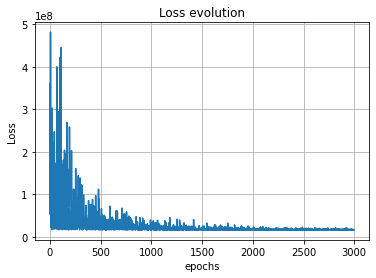

In [24]:
L = VI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

In [25]:
# extract the parameters of the posterior
m.posterior(["w", "w0"]).parameters()

{'w0': {'name': 'w0',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 1.3824779,
  'loc': 0.12997118},
 'w': {'name': 'w',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.47753108],
         [0.23068522],
         [0.64570665],
         [1.3164208 ],
         [1.1571425 ],
         [0.90625733],
         [0.19262601],
         [0.5677754 ],
         [0.49065953],
         [0.08069825],
         [0.4431073 ],
         [0.08541942],
         [0.561361  ]], dtype=float32),
  'loc': array([[-0.1458022 ],
         [ 0.12772268],
         [-0.01956875],
         [ 0.83967984],
         [ 0.09187422],
         [ 0.21405187],
         [ 0.07097021],
         [ 0.09639793],
         [-0.00374777],
         [ 0.02288223],
         [ 0.07786758],
         [ 0.0685137 ],
         [-0.19644162]], dtype=float32)}}

In [55]:
w = m.posterior(["w"]).parameters()["loc"]
w_0 = m.posterior(["w0"]).parameters()["loc"]
print("W: ", w)
print("W0: ", w_0)

W:  [[-0.1458022 ]
 [ 0.12772268]
 [-0.01956875]
 [ 0.83967984]
 [ 0.09187422]
 [ 0.21405187]
 [ 0.07097021]
 [ 0.09639793]
 [-0.00374777]
 [ 0.02288223]
 [ 0.07786758]
 [ 0.0685137 ]
 [-0.19644162]]
W0:  0.12997118


In [52]:
def predictor(x):
    return w_0 + x @ w

In [53]:
print("R² - Bayesian linear Regressor: ", r2_score(y_test, predictor(X_test)))
lr = LinearRegression()
lr.fit(X_train, y_train)
print("R² - Linear Regressor", r2_score(y_test, lr.predict(X_test)))

R² - Bayesian linear Regressor:  -5.011117207427057
R² - Linear Regressor 0.6687594935356307


In [56]:
print(lr.parameters())

AttributeError: 'LinearRegression' object has no attribute 'parameters'